# 🎮 Steam インディーゲーム市場分析ダッシュボード

## インタラクティブな市場洞察とデータ可視化

このノートブックは、Steamプラットフォームのインディーゲーム市場を分析し、データ駆動型の洞察を提供します。

In [1]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import os
from dotenv import load_dotenv
import warnings
from datetime import datetime
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# 警告を無視
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ ライブラリのインポート完了")
print(f"📅 実行時刻: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ ライブラリのインポート完了
📅 実行時刻: 2025-06-14 04:45:30


In [2]:
# データベース接続とデータ読み込み
load_dotenv()

def load_game_data():
    """データベースからゲームデータを読み込み"""
    
    # データベース接続設定
    db_config = {
        "host": os.getenv("POSTGRES_HOST", "postgres"),
        "port": int(os.getenv("POSTGRES_PORT", 5432)),
        "database": os.getenv("POSTGRES_DB", "steam_analytics"),
        "user": os.getenv("POSTGRES_USER", "steam_user"),
        "password": os.getenv("POSTGRES_PASSWORD", "steam_password"),
    }
    
    engine = create_engine(
        f"postgresql://{db_config['user']}:{db_config['password']}@"
        f"{db_config['host']}:{db_config['port']}/{db_config['database']}"
    )
    
    # データ取得クエリ
    query = text("""
        SELECT 
            app_id,
            name,
            type,
            is_free,
            developers,
            publishers,
            price_final,
            genres,
            categories,
            positive_reviews,
            negative_reviews,
            total_reviews,
            platforms_windows,
            platforms_mac,
            platforms_linux,
            created_at
        FROM games
        WHERE type = 'game'
        ORDER BY created_at DESC;
    """)
    
    df = pd.read_sql_query(query, engine)
    
    # データ前処理
    df['price_usd'] = df['price_final'] / 100
    df.loc[df['is_free'] == True, 'price_usd'] = 0
    
    # インディーゲーム判定
    df['is_indie'] = df['genres'].apply(
        lambda x: bool(x and any('Indie' in str(genre) for genre in x if genre))
    )
    
    # プラットフォーム数
    df['platform_count'] = (
        df['platforms_windows'].astype(int) + 
        df['platforms_mac'].astype(int) + 
        df['platforms_linux'].astype(int)
    )
    
    # ジャンル処理
    df['primary_genre'] = df['genres'].apply(
        lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Other'
    )
    
    # 価格カテゴリ
    def price_category(price):
        if price == 0:
            return 'Free'
        elif price < 5:
            return 'Budget ($0-5)'
        elif price < 15:
            return 'Mid-range ($5-15)'
        elif price < 30:
            return 'Premium ($15-30)'
        else:
            return 'AAA ($30+)'
    
    df['price_category'] = df['price_usd'].apply(price_category)
    
    return df

# データ読み込み実行
print("🔄 データ読み込み中...")
df = load_game_data()
print(f"✅ データ読み込み完了: {len(df):,}件のゲーム")
print(f"🎮 インディーゲーム: {len(df[df['is_indie']==True]):,}件")

🔄 データ読み込み中...
✅ データ読み込み完了: 288件のゲーム
🎮 インディーゲーム: 208件


## 📊 市場概要統計

In [3]:
# 市場概要統計の表示
def display_market_overview(df):
    """市場概要統計を表示"""
    
    total_games = len(df)
    indie_games = len(df[df['is_indie'] == True])
    indie_ratio = indie_games / total_games * 100
    
    paid_games = df[df['price_usd'] > 0]
    avg_price = paid_games['price_usd'].mean() if len(paid_games) > 0 else 0
    
    free_games = len(df[df['is_free'] == True])
    avg_platforms = df['platform_count'].mean()
    
    # HTML形式で統計表示
    html = f"""
    <div style="display: flex; justify-content: space-around; margin: 20px 0;">
        <div style="text-align: center; padding: 20px; background: #f8f9fa; border-radius: 10px; border-left: 4px solid #007bff;">
            <h3 style="color: #007bff; margin: 0;">{total_games:,}</h3>
            <p style="margin: 5px 0 0 0; color: #666;">総ゲーム数</p>
        </div>
        <div style="text-align: center; padding: 20px; background: #f8f9fa; border-radius: 10px; border-left: 4px solid #28a745;">
            <h3 style="color: #28a745; margin: 0;">{indie_games:,}</h3>
            <p style="margin: 5px 0 0 0; color: #666;">インディーゲーム ({indie_ratio:.1f}%)</p>
        </div>
        <div style="text-align: center; padding: 20px; background: #f8f9fa; border-radius: 10px; border-left: 4px solid #ffc107;">
            <h3 style="color: #e67e00; margin: 0;">${avg_price:.2f}</h3>
            <p style="margin: 5px 0 0 0; color: #666;">平均価格</p>
        </div>
        <div style="text-align: center; padding: 20px; background: #f8f9fa; border-radius: 10px; border-left: 4px solid #dc3545;">
            <h3 style="color: #dc3545; margin: 0;">{free_games:,}</h3>
            <p style="margin: 5px 0 0 0; color: #666;">無料ゲーム</p>
        </div>
    </div>
    """
    
    display(HTML(html))
    
    return {
        'total_games': total_games,
        'indie_games': indie_games,
        'indie_ratio': indie_ratio,
        'avg_price': avg_price,
        'free_games': free_games,
        'avg_platforms': avg_platforms
    }

# 統計表示
stats = display_market_overview(df)

## 🎮 インタラクティブ分析

In [4]:
# インタラクティブなジャンル分析
@interact
def analyze_genres(show_indie_only=True, max_price=widgets.FloatSlider(value=50, min=0, max=100, step=5, description='最大価格($)')):
    """インタラクティブなジャンル分析"""
    
    # データフィルタリング
    df_filtered = df.copy()
    
    if show_indie_only:
        df_filtered = df_filtered[df_filtered['is_indie'] == True]
    
    df_filtered = df_filtered[df_filtered['price_usd'] <= max_price]
    
    if len(df_filtered) == 0:
        print("選択した条件に合うゲームがありません。")
        return
    
    print(f"📊 分析対象: {len(df_filtered):,}件のゲーム")
    
    # ジャンル分析
    genre_counts = df_filtered['primary_genre'].value_counts().head(10)
    
    # 可視化
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # ジャンル分布
    genre_counts.plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('人気ジャンル TOP 10', fontsize=14, fontweight='bold')
    ax1.set_xlabel('ジャンル')
    ax1.set_ylabel('ゲーム数')
    ax1.tick_params(axis='x', rotation=45)
    
    # 価格帯分布
    price_dist = df_filtered['price_category'].value_counts()
    ax2.pie(price_dist.values, labels=price_dist.index, autopct='%1.1f%%', startangle=90)
    ax2.set_title('価格帯分布', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 統計テーブル
    genre_stats = df_filtered.groupby('primary_genre').agg({
        'app_id': 'count',
        'price_usd': 'mean',
        'platform_count': 'mean'
    }).round(2)
    
    genre_stats.columns = ['ゲーム数', '平均価格($)', '平均プラットフォーム数']
    genre_stats = genre_stats.sort_values('ゲーム数', ascending=False).head(10)
    
    print("\n📈 ジャンル別詳細統計:")
    display(genre_stats)

interactive(children=(Checkbox(value=True, description='show_indie_only'), FloatSlider(value=50.0, description…

## 💰 価格分析

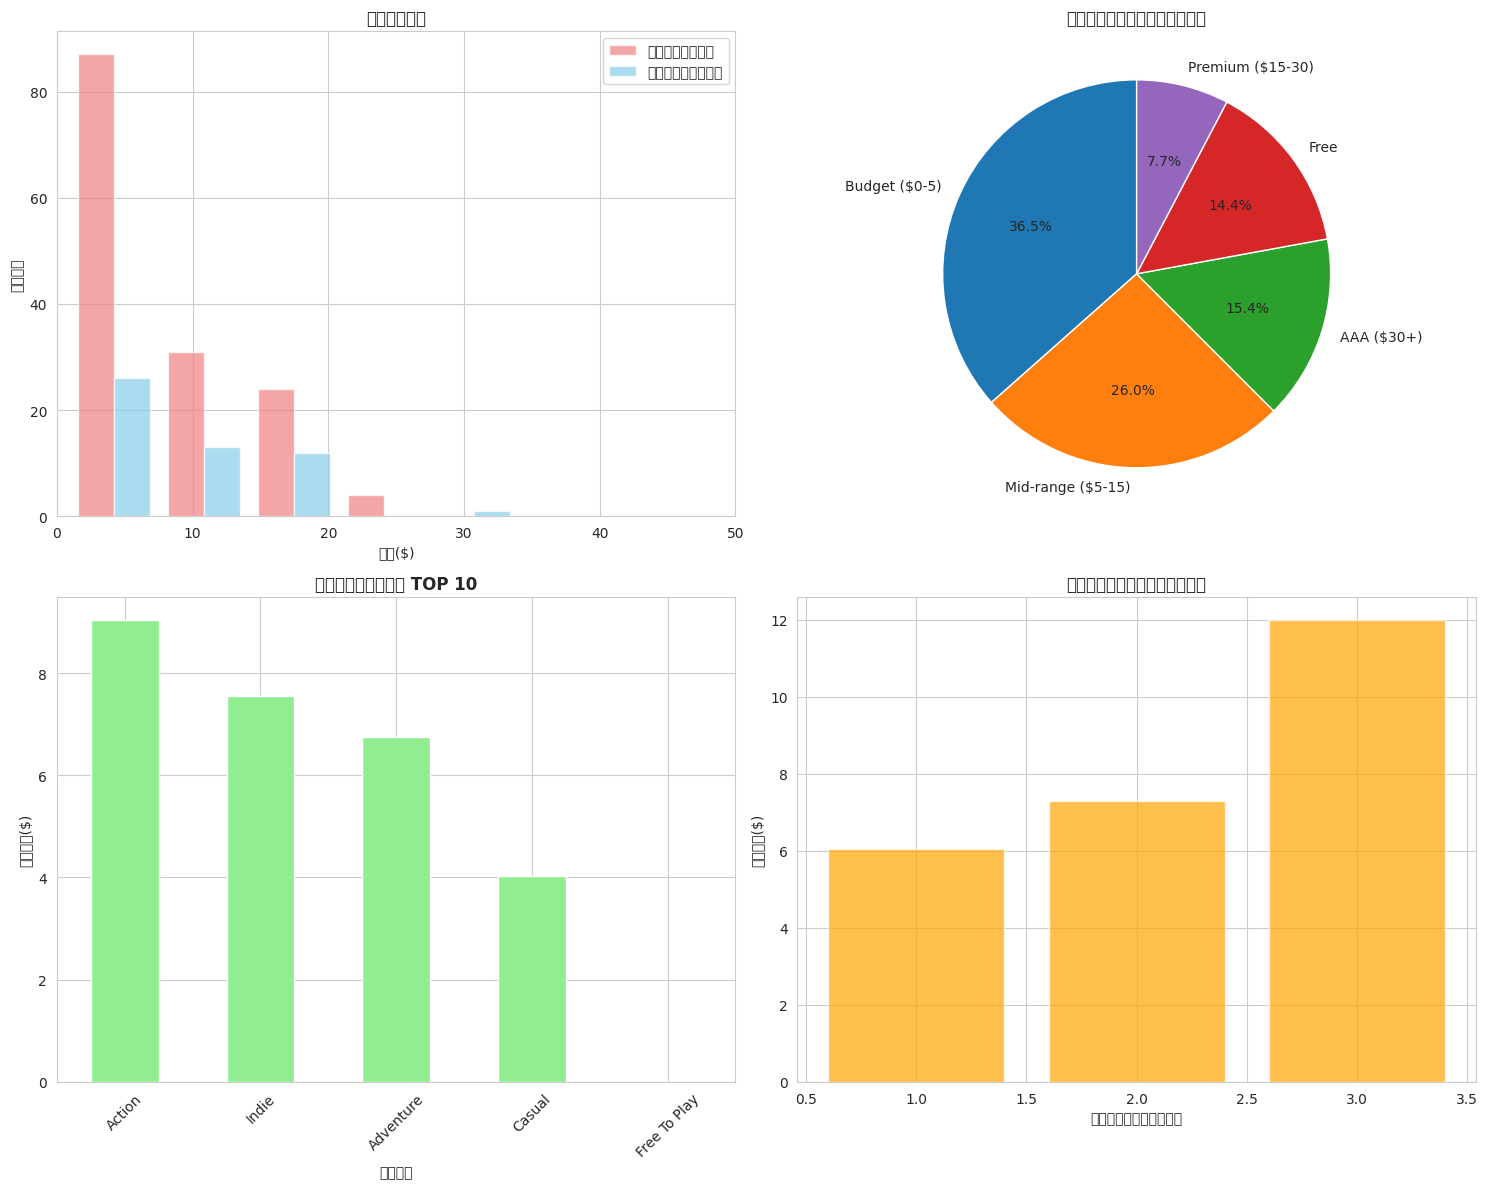

💰 価格統計サマリー:
インディーゲーム平均価格: $9.00
インディーゲーム中央値: $4.99
非インディーゲーム平均価格: $10.97
最高価格インディーゲーム: $199.99


In [5]:
# 価格分析の可視化
def price_analysis(df):
    """価格分析の実行"""
    
    indie_df = df[df['is_indie'] == True]
    non_indie_df = df[df['is_indie'] == False]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. 価格分布比較
    indie_prices = indie_df[indie_df['price_usd'] > 0]['price_usd']
    non_indie_prices = non_indie_df[non_indie_df['price_usd'] > 0]['price_usd']
    
    axes[0,0].hist([indie_prices, non_indie_prices], bins=30, alpha=0.7, 
                   label=['インディーゲーム', '非インディーゲーム'], color=['lightcoral', 'skyblue'])
    axes[0,0].set_title('価格分布比較', fontweight='bold')
    axes[0,0].set_xlabel('価格($)')
    axes[0,0].set_ylabel('ゲーム数')
    axes[0,0].legend()
    axes[0,0].set_xlim(0, 50)
    
    # 2. 価格帯別シェア
    price_share = indie_df['price_category'].value_counts()
    axes[0,1].pie(price_share.values, labels=price_share.index, autopct='%1.1f%%', startangle=90)
    axes[0,1].set_title('インディーゲーム価格帯シェア', fontweight='bold')
    
    # 3. ジャンル別平均価格
    genre_price = indie_df.groupby('primary_genre')['price_usd'].mean().sort_values(ascending=False).head(10)
    genre_price.plot(kind='bar', ax=axes[1,0], color='lightgreen')
    axes[1,0].set_title('ジャンル別平均価格 TOP 10', fontweight='bold')
    axes[1,0].set_xlabel('ジャンル')
    axes[1,0].set_ylabel('平均価格($)')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. プラットフォーム数vs価格
    platform_price = indie_df.groupby('platform_count')['price_usd'].mean()
    axes[1,1].bar(platform_price.index, platform_price.values, color='orange', alpha=0.7)
    axes[1,1].set_title('プラットフォーム数別平均価格', fontweight='bold')
    axes[1,1].set_xlabel('対応プラットフォーム数')
    axes[1,1].set_ylabel('平均価格($)')
    
    plt.tight_layout()
    plt.show()
    
    # 価格統計
    print("💰 価格統計サマリー:")
    print(f"インディーゲーム平均価格: ${indie_prices.mean():.2f}")
    print(f"インディーゲーム中央値: ${indie_prices.median():.2f}")
    print(f"非インディーゲーム平均価格: ${non_indie_prices.mean():.2f}")
    print(f"最高価格インディーゲーム: ${indie_prices.max():.2f}")

price_analysis(df)

## 🖥️ プラットフォーム戦略分析

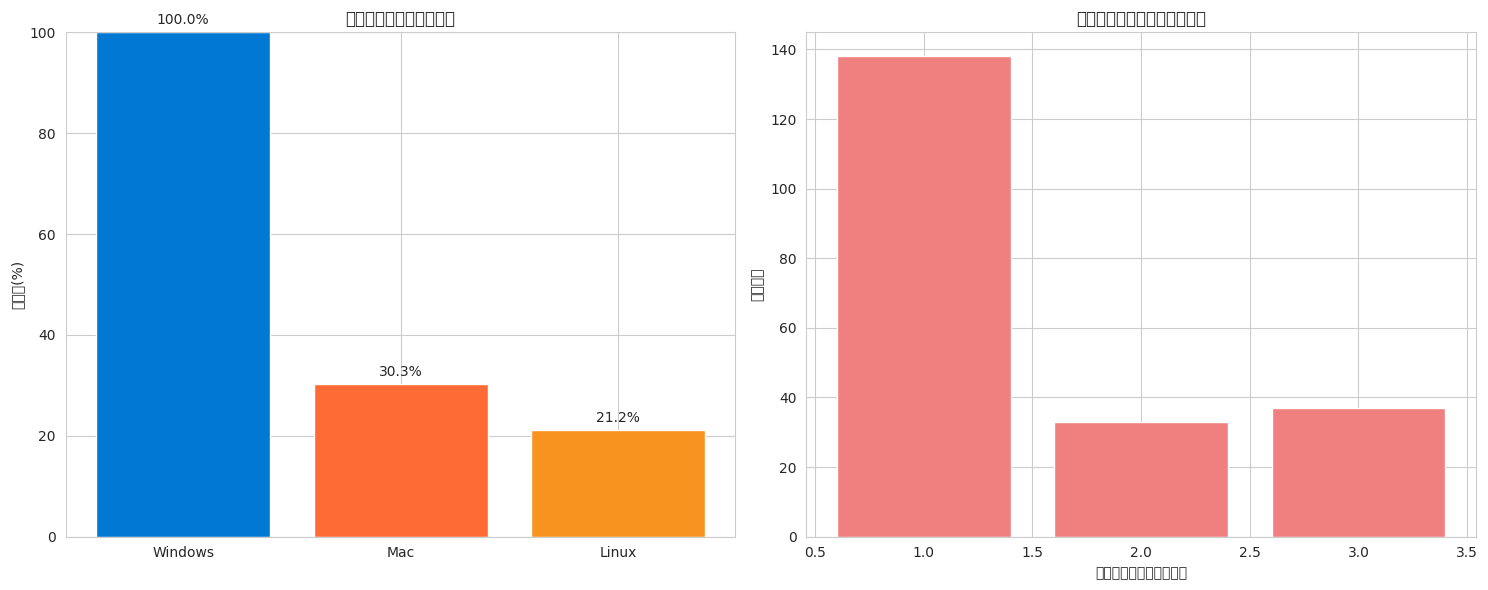

🖥️ プラットフォーム戦略分析:
単一プラットフォーム: 138件 (66.3%)
マルチプラットフォーム: 70件 (33.7%)
Windows対応率: 100.0%
Mac対応率: 30.3%
Linux対応率: 21.2%


In [6]:
# プラットフォーム分析
def platform_analysis(df):
    """プラットフォーム戦略分析"""
    
    indie_df = df[df['is_indie'] == True]
    
    # プラットフォーム対応率
    platform_stats = {
        'Windows': indie_df['platforms_windows'].mean() * 100,
        'Mac': indie_df['platforms_mac'].mean() * 100,
        'Linux': indie_df['platforms_linux'].mean() * 100
    }
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # プラットフォーム対応率
    platforms = list(platform_stats.keys())
    rates = list(platform_stats.values())
    
    bars = ax1.bar(platforms, rates, color=['#0078d4', '#ff6b35', '#f7931e'])
    ax1.set_title('プラットフォーム対応率', fontweight='bold')
    ax1.set_ylabel('対応率(%)')
    ax1.set_ylim(0, 100)
    
    # バーの上に数値表示
    for bar, rate in zip(bars, rates):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{rate:.1f}%', ha='center', va='bottom')
    
    # プラットフォーム数分布
    platform_dist = indie_df['platform_count'].value_counts().sort_index()
    ax2.bar(platform_dist.index, platform_dist.values, color='lightcoral')
    ax2.set_title('対応プラットフォーム数分布', fontweight='bold')
    ax2.set_xlabel('対応プラットフォーム数')
    ax2.set_ylabel('ゲーム数')
    
    plt.tight_layout()
    plt.show()
    
    # 戦略分析
    single_platform = len(indie_df[indie_df['platform_count'] == 1])
    multi_platform = len(indie_df[indie_df['platform_count'] > 1])
    
    print("🖥️ プラットフォーム戦略分析:")
    print(f"単一プラットフォーム: {single_platform:,}件 ({single_platform/len(indie_df)*100:.1f}%)")
    print(f"マルチプラットフォーム: {multi_platform:,}件 ({multi_platform/len(indie_df)*100:.1f}%)")
    print(f"Windows対応率: {platform_stats['Windows']:.1f}%")
    print(f"Mac対応率: {platform_stats['Mac']:.1f}%")
    print(f"Linux対応率: {platform_stats['Linux']:.1f}%")

platform_analysis(df)

## 💡 市場洞察と推奨事項

In [7]:
# 市場洞察の生成
def generate_insights(df):
    """データ基づく市場洞察の生成"""
    
    indie_df = df[df['is_indie'] == True]
    
    # 基本統計
    total_games = len(df)
    indie_games = len(indie_df)
    indie_ratio = indie_games / total_games * 100
    
    avg_price = indie_df[indie_df['price_usd'] > 0]['price_usd'].mean()
    median_price = indie_df[indie_df['price_usd'] > 0]['price_usd'].median()
    
    # 人気ジャンル
    top_genre = indie_df['primary_genre'].value_counts().index[0]
    top_genre_count = indie_df['primary_genre'].value_counts().iloc[0]
    
    # プラットフォーム統計
    windows_rate = indie_df['platforms_windows'].mean() * 100
    multi_platform_rate = len(indie_df[indie_df['platform_count'] > 1]) / len(indie_df) * 100
    
    # HTML形式での洞察表示
    insights_html = f"""
    <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white; padding: 20px; border-radius: 15px; margin: 20px 0;">
        <h2 style="margin-top: 0; text-align: center;">💡 市場洞察レポート</h2>
        
        <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px; margin: 20px 0;">
            <div style="background: rgba(255,255,255,0.1); padding: 15px; border-radius: 10px;">
                <h3>🎯 市場構造</h3>
                <p>インディーゲームがSteam市場の<strong>{indie_ratio:.1f}%</strong>を占め、主要セグメントを形成。
                多様な開発者による活発な競争市場。</p>
            </div>
            
            <div style="background: rgba(255,255,255,0.1); padding: 15px; border-radius: 10px;">
                <h3>💰 価格戦略</h3>
                <p>平均価格<strong>${avg_price:.2f}</strong>、中央値<strong>${median_price:.2f}</strong>。
                低価格戦略が主流だが、品質による差別化で高価格帯も成功可能。</p>
            </div>
            
            <div style="background: rgba(255,255,255,0.1); padding: 15px; border-radius: 10px;">
                <h3>🎮 ジャンル動向</h3>
                <p>最人気ジャンル「<strong>{top_genre}</strong>」({top_genre_count}件)。
                特定ジャンルの独占はなく、ニッチ分野での専門化が有効。</p>
            </div>
            
            <div style="background: rgba(255,255,255,0.1); padding: 15px; border-radius: 10px;">
                <h3>🖥️ プラットフォーム戦略</h3>
                <p>Windows対応率<strong>{windows_rate:.1f}%</strong>、マルチプラットフォーム<strong>{multi_platform_rate:.1f}%</strong>。
                Windows必須、Mac/Linux対応で差別化可能。</p>
            </div>
        </div>
    </div>
    
    <div style="background: #e8f5e8; padding: 20px; border-radius: 15px; border-left: 5px solid #28a745;">
        <h3 style="color: #28a745; margin-top: 0;">🚀 新規参入者への推奨事項</h3>
        <ol style="color: #2c5530;">
            <li><strong>価格設定</strong>: ${median_price:.2f}前後の価格設定が市場標準</li>
            <li><strong>プラットフォーム</strong>: Windows必須、Mac/Linux対応で差別化</li>
            <li><strong>ジャンル選択</strong>: ニッチジャンルでの専門化による競争回避</li>
            <li><strong>品質重視</strong>: ユーザーレビューと評価の重要性</li>
            <li><strong>コミュニティ</strong>: 開発段階からのコミュニティ構築</li>
        </ol>
    </div>
    
    <div style="background: #fff3cd; padding: 20px; border-radius: 15px; border-left: 5px solid #ffc107; margin-top: 20px;">
        <h3 style="color: #856404; margin-top: 0;">📈 成長機会</h3>
        <ul style="color: #856404;">
            <li>Linux対応による差別化（現在の対応率が低い）</li>
            <li>未開拓ジャンルでの専門化</li>
            <li>コミュニティ重視の開発戦略</li>
            <li>適切な価格設定による競争力確保</li>
        </ul>
    </div>
    """
    
    display(HTML(insights_html))
    
    # 数値サマリー
    print("\n📊 数値サマリー:")
    print(f"総ゲーム数: {total_games:,}件")
    print(f"インディーゲーム: {indie_games:,}件 ({indie_ratio:.1f}%)")
    print(f"平均価格: ${avg_price:.2f}")
    print(f"最人気ジャンル: {top_genre} ({top_genre_count}件)")
    print(f"マルチプラットフォーム率: {multi_platform_rate:.1f}%")

generate_insights(df)


📊 数値サマリー:
総ゲーム数: 288件
インディーゲーム: 208件 (72.2%)
平均価格: $9.00
最人気ジャンル: Action (96件)
マルチプラットフォーム率: 33.7%


## 🔄 データ更新

最新のデータで分析を更新したい場合は、以下のセルを実行してください：

In [8]:
# データの再読み込みと再分析
def refresh_analysis():
    """データを再読み込みして全分析を更新"""
    
    print("🔄 データを再読み込み中...")
    global df
    df = load_game_data()
    
    print(f"✅ 最新データ: {len(df):,}件のゲーム")
    print(f"🎮 インディーゲーム: {len(df[df['is_indie']==True]):,}件")
    print(f"📅 更新時刻: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # 市場概要を再表示
    display_market_overview(df)

# 更新ボタン
refresh_button = widgets.Button(description="📊 データ更新", button_style='info')

def on_refresh_clicked(b):
    refresh_analysis()

refresh_button.on_click(on_refresh_clicked)
display(refresh_button)

print("\n💡 このノートブックの使い方:")
print("- 各セクションのセルを順番に実行")
print("- インタラクティブウィジェットで条件を変更")
print("- '📊 データ更新'ボタンで最新データに更新")
print("- ブラウザで http://localhost:8889 からアクセス可能")

Button(button_style='info', description='📊 データ更新', style=ButtonStyle())


💡 このノートブックの使い方:
- 各セクションのセルを順番に実行
- インタラクティブウィジェットで条件を変更
- '📊 データ更新'ボタンで最新データに更新
- ブラウザで http://localhost:8889 からアクセス可能
